# drop all missing value in social sport
data = data.dropna(subset=['Social support'])

#impute missing values with prediction model
for column in data.columns:
    if data[column].isnull().any() and column not in ['Life Ladder', 'Social support Category']:
        # Define predictors and target
        X = data[['Life Ladder', 'Social support']]
        y = data[column]
        
        # Train on non-missing data
        X_train = X.loc[~y.isna()]
        y_train = y.dropna()
        
        if len(X_train) > 0:
            # Train model
            model = LinearRegression()
            model.fit(X_train, y_train)
            
            # Predict missing values
            X_missing = X.loc[y.isna()]
            data.loc[y.isna(), column] = model.predict(X_missing)

# **📊World Happiness Data**

#### **Overview**
In this notebook, we will:

Explore the data to understand its structure.
Handle missing values effectively.
Preprocess the data for modeling.
Build and evaluate a neural network

In [54]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


# Load Data

In [55]:
data=pd.read_csv('World Happiness Report 2024.csv')


# Exploratry Data Analysis

In [56]:
data.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.164055,0.881686,0.414297,0.258195
1,Afghanistan,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.187297,0.850035,0.481421,0.237092
2,Afghanistan,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.117861,0.706766,0.516907,0.275324
3,Afghanistan,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.160098,0.731109,0.479835,0.267175
4,Afghanistan,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.234157,0.775620,0.613513,0.267919


In [57]:
# chek min and max values
print(data['Life Ladder'].max())
print(data['Life Ladder'].min())

8.01893424987793
1.2812711000442505


In [58]:
print(data['Social support'].max())
print(data['Social support'].min())

0.9873434901237488
0.2282172292470932


In [59]:
print(data['Freedom to make life choices'].max())
print(data['Freedom to make life choices'].min())

0.985177755355835
0.2283011972904205


In [60]:
data.shape

(2363, 11)

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


In [62]:
data.isnull().sum().sort_values(ascending=True)

Country name                          0
year                                  0
Life Ladder                           0
Social support                       13
Negative affect                      16
Positive affect                      24
Log GDP per capita                   28
Freedom to make life choices         36
Healthy life expectancy at birth     63
Generosity                           81
Perceptions of corruption           125
dtype: int64

# Data Visualization

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

__Visualization Type: Histogram with KDE.__                 
__Description: Visualizes the distribution of life satisfaction scores.__

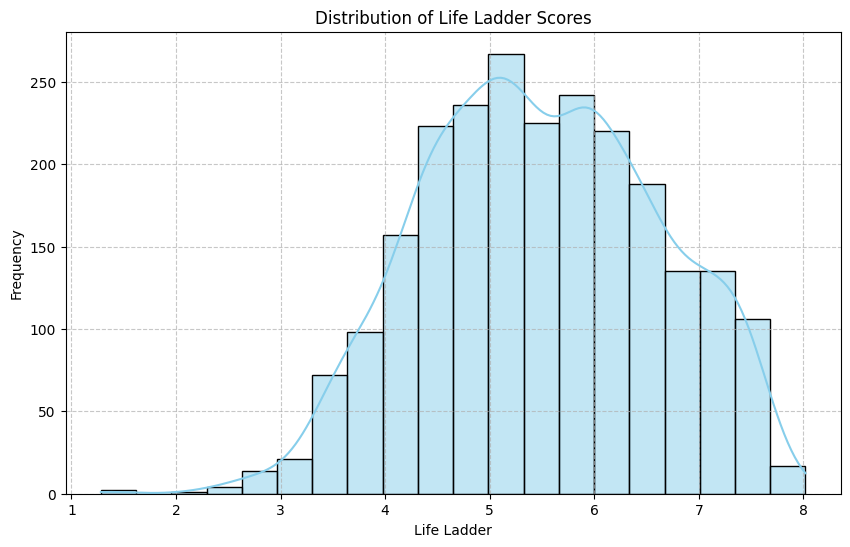

In [64]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Life Ladder'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Life Ladder Scores')
plt.xlabel('Life Ladder')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


**Visualization Type: Heatmap**                          
**Description: Shows correlations between all numerical features in the dataset.**

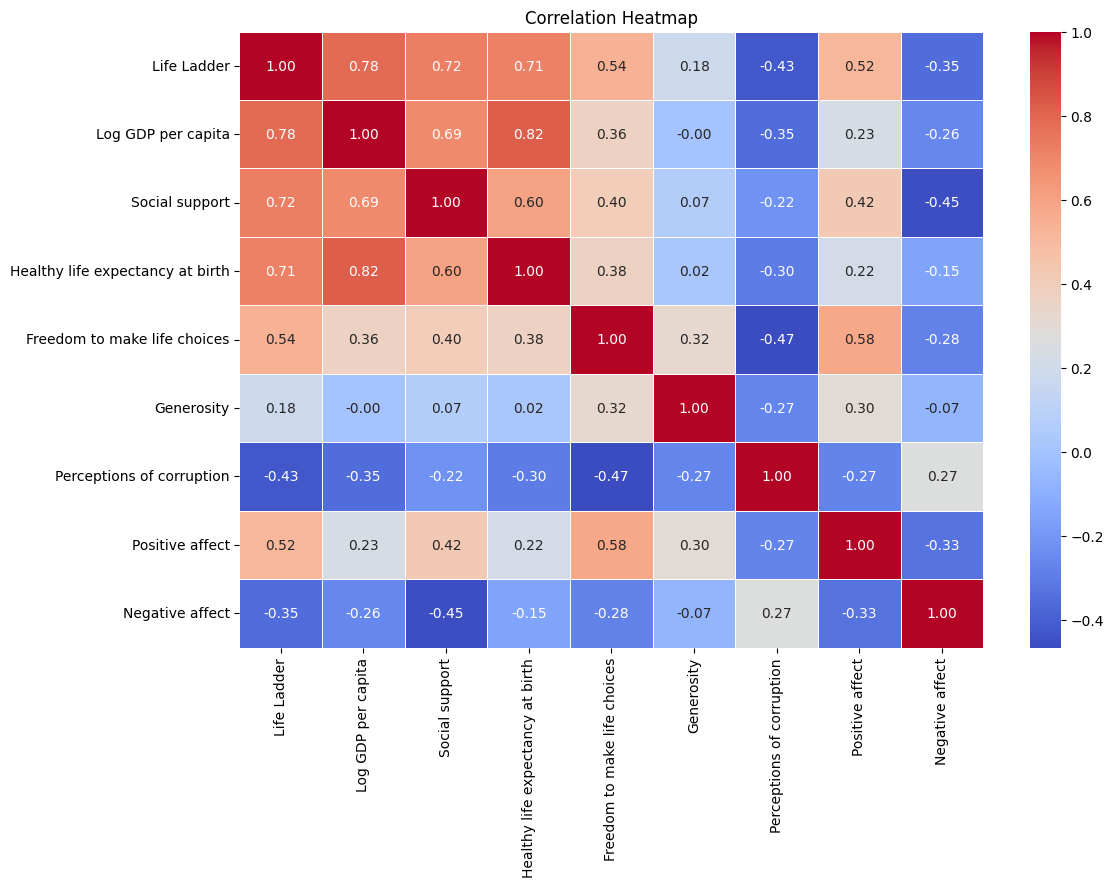

In [65]:

plt.figure(figsize=(12, 8))
correlation_matrix = data[['Life Ladder', 'Log GDP per capita', 'Social support', 
                         'Healthy life expectancy at birth', 'Freedom to make life choices', 
                         'Generosity', 'Perceptions of corruption', 'Positive affect', 
                         'Negative affect']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


**Visualization Type: Scatter Plot**                   
**Description: Shows the relationship between GDP per capita and life satisfaction.**

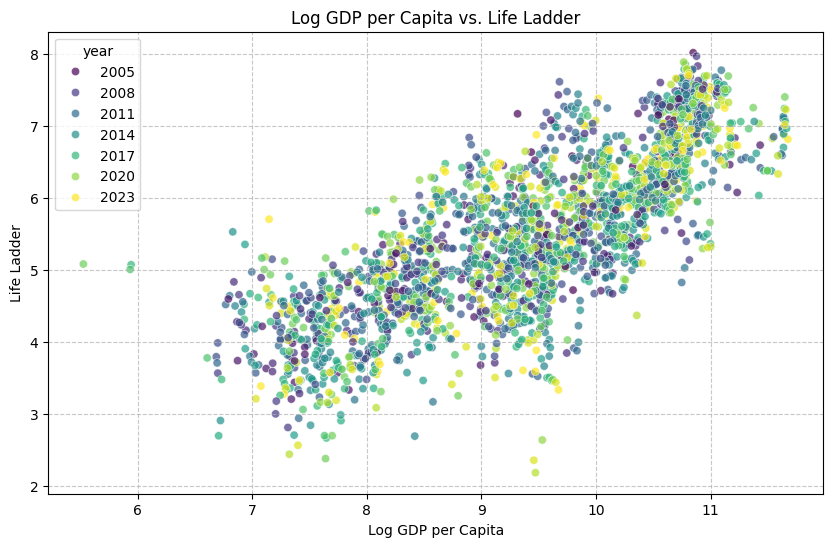

In [66]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Log GDP per capita', y='Life Ladder', hue='year', palette='viridis', alpha=0.7)
plt.title('Log GDP per Capita vs. Life Ladder')
plt.xlabel('Log GDP per Capita')
plt.ylabel('Life Ladder')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


**Visualization Type: Box Plot**                                             
**Description: Compares the distribution of positive and negative affect across different years**.


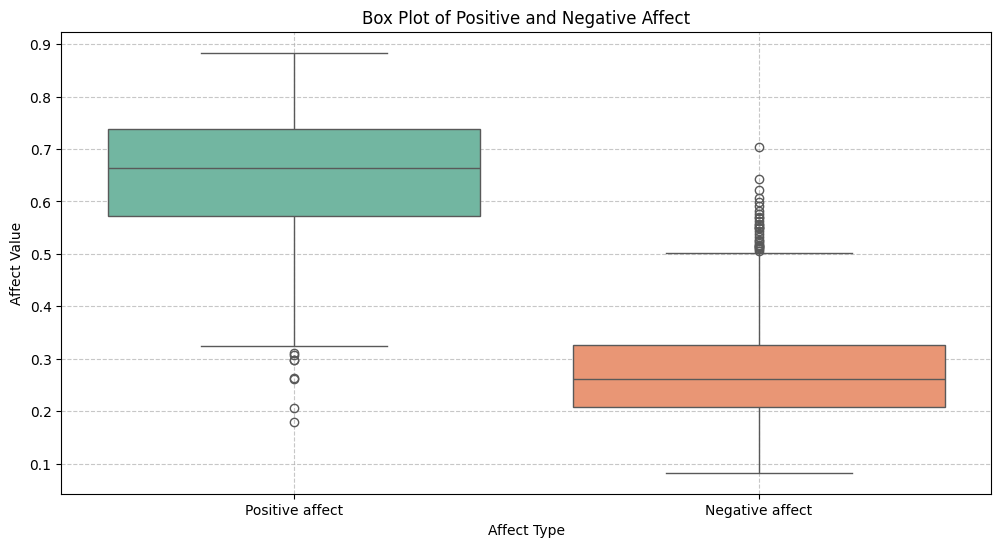

In [67]:

plt.figure(figsize=(12, 6))
melted_df = data.melt(id_vars='year', value_vars=['Positive affect', 'Negative affect'], 
                    var_name='Affect Type', value_name='Affect Value')
sns.boxplot(data=melted_df, x='Affect Type', y='Affect Value', palette='Set2')
plt.title('Box Plot of Positive and Negative Affect')
plt.xlabel('Affect Type')
plt.ylabel('Affect Value')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# Data Preprocessing

In [68]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer


#### **Handle Missing Values**

In [69]:
data.isnull().sum()

Country name                          0
year                                  0
Life Ladder                           0
Log GDP per capita                   28
Social support                       13
Healthy life expectancy at birth     63
Freedom to make life choices         36
Generosity                           81
Perceptions of corruption           125
Positive affect                      24
Negative affect                      16
dtype: int64

In [70]:
data = data.dropna(subset=['Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Positive affect', 'Negative affect'])


#### **Features Engineering**

In [71]:
# Define bins based on min and max values
bins = [0, 0.3, 0.4, 0.6, 0.7, 1]
labels = ['Very Low', 'Low', 'Moderate', 'High','Extreme']

# Create binned feature
data['Social support Category'] = pd.cut(data['Social support'], bins=bins, labels=labels)


In [72]:
# Create Happiness Index
data['Happiness Index'] = (data['Positive affect'] - data['Negative affect']) / (data['Positive affect'] + data['Negative affect'] + 1)

# Define thresholds for categorization
def categorize_happiness(index):
    if index < -0.2:
        return 'Very Sad'
    elif -0.2 <= index < -0.1:
        return 'Sad'
    elif -0.1 <= index < 0.1:
        return 'Neutral'
    elif 0.1 <= index < 0.3:
        return 'Happy'
    else:
        return 'Very Happy'

# Apply categorization
data['Happiness Category'] = data['Happiness Index'].apply(categorize_happiness)


#### **Encoding**

In [73]:

# Initialize LabelEncoder
label_encoder = LabelEncoder()

data['Social support Category'] = label_encoder.fit_transform(data['Social support Category'])

# Define the mapping dictionary for Happiness Category
happiness_mapping = {
    'Very Sad': 0,
    'Sad': 1,
    'Neutral': 2,
    'Happy': 3,
    'Very Happy': 4
}
data['Happiness Category'] = data['Happiness Category'].map(happiness_mapping)

data= data.drop(columns=['Country name']) 


# **Model Building**

In [74]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

#### **Seprate Faetures and Target**

In [84]:
 #Separate features and target

X = data.drop(['Happiness Category','Social support Category'], axis=1)
y = data['Happiness Category']
# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


#### **Neural Network Model**

In [85]:
# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='linear')  # Changed activation for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


In [86]:
# Training
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2)



Epoch 1/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.9889 - mae: 2.2936 - val_loss: 1.8826 - val_mae: 1.2274
Epoch 2/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2283 - mae: 1.2548 - val_loss: 0.7780 - val_mae: 0.7338
Epoch 3/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8646 - mae: 1.1320 - val_loss: 0.5967 - val_mae: 0.6402
Epoch 4/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5739 - mae: 1.0107 - val_loss: 0.4359 - val_mae: 0.5300
Epoch 5/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2346 - mae: 0.9237 - val_loss: 0.4090 - val_mae: 0.5130
Epoch 6/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1647 - mae: 0.8803 - val_loss: 0.3602 - val_mae: 0.4772
Epoch 7/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1910 - mae: 0.8964 - val_loss: 0.3253 - val_mae: 0.4534
Epoch 8/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9836 - mae: 0.7973 - val_loss: 0.4349 - val_mae: 0.5448
Epoch 9/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9822 - mae:

#### **Evaluation**

In [80]:
# Evaluation
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_mae:.2f}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1542 - mae: 0.3153 
Test MAE: 0.32


# Summary
#### 1. Exploratory Data Analysis (EDA)
- **Inspect Data**: Load and review dataset to check for missing values and understand distributions.
- **Visualize**: Use plots (histograms, scatter plots) to explore feature distributions and relationships.

#### 2. Data Preprocessing
- Handle Missing Values: Fill or remove missing values as needed.
- Feature Scaling: Standardize or normalize features to ensure they’re on a similar scale.
- Encode Categorical Variables: Convert categorical data into numerical format using techniques like one-hot encoding.
- Split Data: Divide the dataset into training, validation, and test sets.

#### 3. Neural Network Training
- Define Model: Specify the architecture, including layers, units, and activation functions.
- Compile Model: Choose the optimizer, loss function, and metrics.
- Train Model: Fit the model on training data and monitor performance on validation data.
- Evaluate Model: Assess the model’s performance on test data and adjust hyperparameters if needed.
